In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from simsimpy import *
import random
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular'

-0.0015509732690498457
0
[1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 0
 1 1 1 0 0 0 1 1 1 1 0 1 0]


Text(0.5, 1.0, 'MSK Signal')

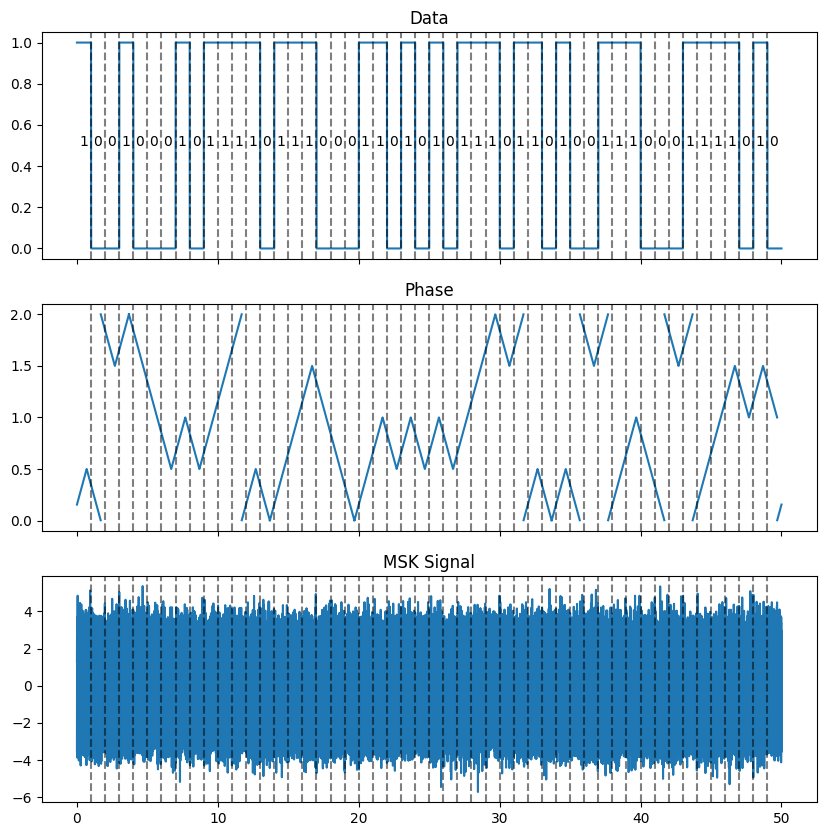

In [8]:
T = 1/200
fc = 20e3
fs = 4e6
L0= 50
offset = np.random.uniform(-T/2, 0)
#offset = 0
phase_offset = 0

print(offset)
print(phase_offset)
s, t, data, phase = generate_msk(L0, 0.5, T, fc, fs, offset=offset, phase_offset=phase_offset)
s_true = s.copy()
s = s + np.random.normal(0, 1, len(s))

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
print(data)
data_plot = np.zeros_like(t)
for n in range(len(data)):
    t1 = int(n*T*fs)
    t2 = int((n+1)*T*fs)
    data_plot[t1:t2] = data[n]

axs[0].plot(t/T, data_plot)
#axs[0].text(0.5,0.5,data[0])

for i in range(1, int(len(data))):
    axs[0].axvline(x=i, color='black', linestyle='--', alpha=0.5)
for i in range(len(data)):
    axs[0].text(i*1+0.15,0.5, data[i])
axs[0].set_title('Data')

phase_plot = phase[phase < 1e-2] = np.nan 
axs[1].plot(t/T, phase/np.pi)
for i in range(1, int(len(data))):
    axs[1].axvline(x=i, color='black', linestyle='--', alpha=0.5)
axs[1].set_title('Phase')

axs[2].plot(t/T, s)
for i in range(1, int(len(data))):
    axs[2].axvline(x=i, color='black', linestyle='--', alpha=0.5)
axs[2].set_title('MSK Signal')

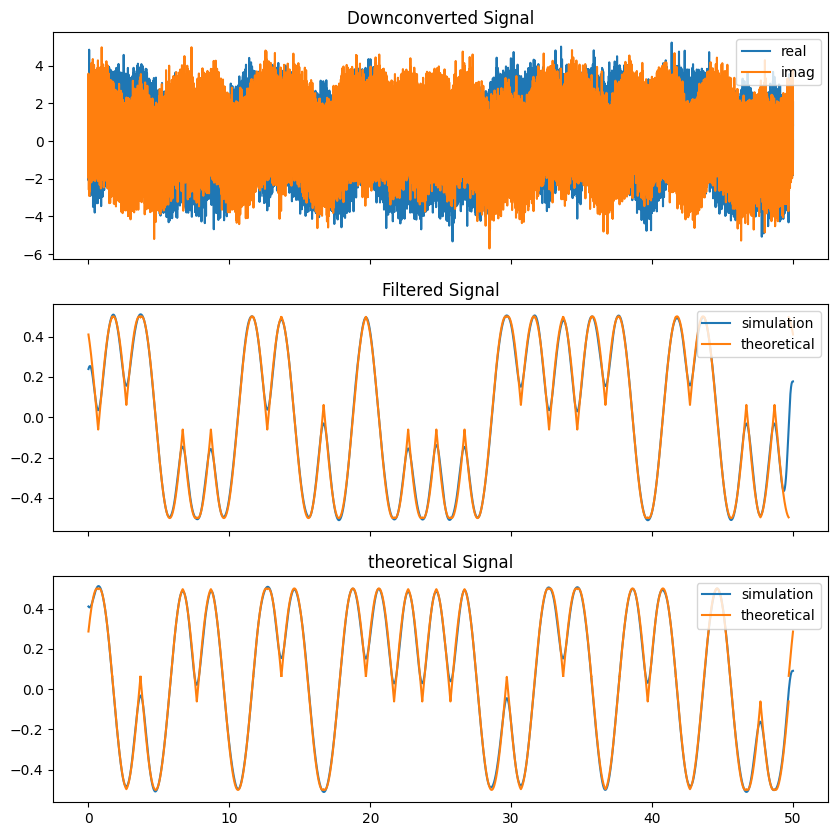

In [9]:
# downconversion

s_down = s*np.exp(-1j*2*np.pi*fc*t)

# filtering
sos = signal.butter(2,1/T, 'low', output='sos', fs=fs)
temp = np.append(np.ones(int(fs*T))*np.mean(s_down[0:int(fs*T)]), s_down)
s_filt = signal.sosfiltfilt(sos, temp)[int(fs*T):]

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

axs[0].plot(t/T, s_down.real, label='real')
axs[0].plot(t/T, s_down.imag, label='imag')
axs[0].set_title('Downconverted Signal')
axs[0].legend(loc='upper right')

axs[1].plot(t/T, s_filt.real, label='simulation')
axs[1].plot(t/T, 1/2*np.exp(1j*(phase -2*np.pi*fc*offset + phase_offset)).real, label='theoretical')
axs[1].set_title('Filtered Signal')
axs[1].legend(loc='upper right')

axs[2].plot(t/T, s_filt.imag, label='simulation')
axs[2].plot(t/T, 1/2*np.exp(1j*(phase -2*np.pi*fc*offset + phase_offset)).imag, label='theoretical')
axs[2].set_title('theoretical Signal')
axs[2].legend(loc='upper right')




# parameter estimation

In [10]:

_, _, tau_hat, theta_hat = phase_and_time_sync(s_filt, int(fs*T),  T , fs, L0)
theta_hat = (theta_hat + 2*np.pi*fc*tau_hat) % (np.pi) - 0.5*np.pi
#theta_hat = (theta_hat + 2*np.pi*fc*offset) % (2*np.pi) - 0.5*np.pi
if tau_hat < 0:
    theta_hat += 0.5*np.pi
print(f'Offset: {np.round(offset,6)} Offset estimated: {np.round(tau_hat,6)}')
print(f'Phase offset: {np.round(phase_offset/np.pi,4)} Phase offset estimated: {np.round(theta_hat/np.pi,4)}')


Offset: -0.001551 Offset estimated: -0.001547
Phase offset: 0.0 Phase offset estimated: 0.1713


# decode

Number of errors: 0
[1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 0
 1 1 1 0 0 0 1 1 1 1 0 1 0]
[1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 0
 1 1 1 0 0 0 1 1 1 1 0 1 0]
0.0


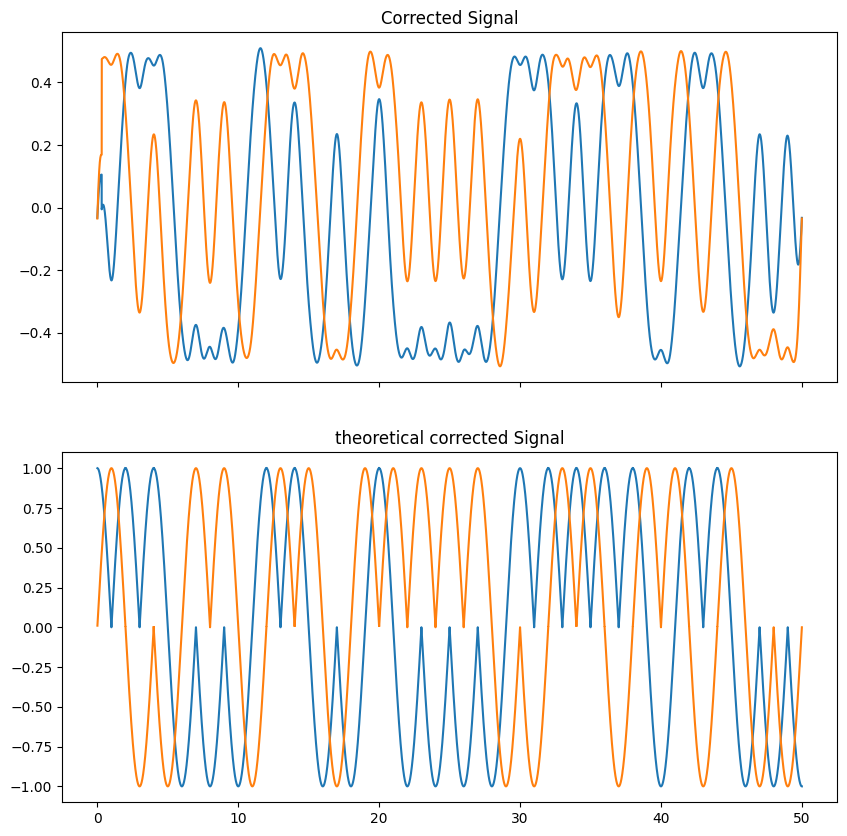

In [11]:
s_corrected = np.roll(s_filt*np.exp(1j*(theta_hat)),-int(tau_hat*fs))

#s_corrected = s_filt ##### remove this line, it is only for testing

decoded_bits, phase_start = viterbi_decoder(s_corrected, int(T*fs))

fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

axs[0].plot(t/T, s_corrected.real, label='real')
axs[0].plot(t/T, s_corrected.imag, label='imag')
axs[0].set_title('Corrected Signal')

axs[1].plot(t/T, np.exp(1j*(np.roll(phase,-int(offset*fs)))).real, label='real')
axs[1].plot(t/T, np.exp(1j*(np.roll(phase,-int(offset*fs)))).imag, label='imag')
axs[1].set_title('theoretical corrected Signal')

print(f'Number of errors: {np.sum(decoded_bits != data)}')
print(data)
print(decoded_bits)
print(phase_start/np.pi)


# recreate signal

(0.0, 0.5)

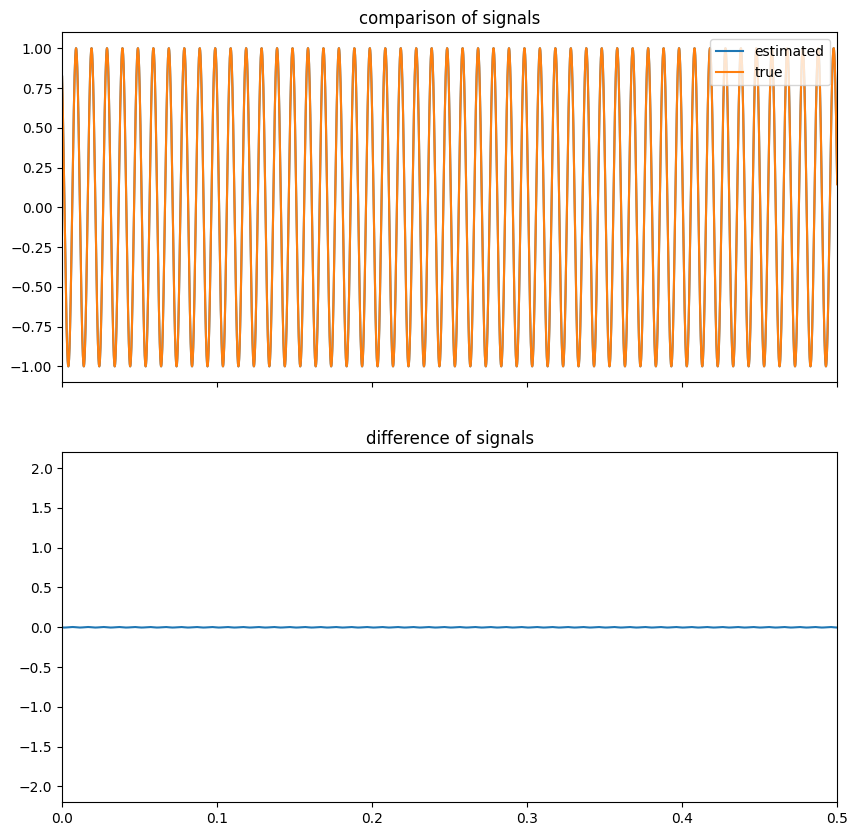

In [12]:

s_est, t_est, phase_est = generate_msk_data(decoded_bits, T, fc, fs, offset=tau_hat, phase_offset=theta_hat)
#s_est, t_est, phase_est = generate_msk_data(decoded_bits, T, fc, fs, offset=offset, phase_offset=phase_offset)

fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

axs[0].plot(t_est/T, s_est.real, label='estimated')
axs[0].plot(t/T, s_true, label='true')
axs[0].legend(loc='upper right')

axs[0].set_title('comparison of signals')

axs[1].plot(t/T, s_true-s_est)
axs[1].set_title('difference of signals')

plt.xlim(0,0.5)
